In [1]:
import numpy as np
import pandas as pd

In [2]:
class Addition():
    def forward(self,X,Y):
        self.X = np.squeeze(np.array(X,dtype=float))
        self.Y = np.squeeze(np.array(Y,dtype=float))
        R = np.add(self.X,self.Y)
        return R
    
    def backward(self,dR):
        dX = 1*dR
        dY = 1*dR
        return [dX, dY]

class Multiply():
    def forward(self,X,Y):
        self.X = np.squeeze(np.array(X,dtype=float))
        self.Y = np.squeeze(np.array(Y,dtype=float))
        R = np.matmul(self.X,self.Y)
        return R
    
    def backward(self,dR):
        X = self.X
        Y = self.Y
        dR = np.squeeze(np.array([dR]))
        if len(dR.shape) == 1:
            if len(X.shape) == 2:
                dY = np.kron(Y,dR)
                dY = np.reshape(dY,(Y.shape[0],dR.shape[0]))
            else:
                dY = np.matmul(Y.T,dR)            
            if len(Y.shape) == 2:
                dX = np.kron(X,dR)
                dX = np.reshape(dX,(X.shape[0],dR.shape[0]))
            else:
                dX = np.matmul(X.T,dR)
        else:
            dX = Y*dR
            dY = X*dR
        return [dX, dY]
    
class Sigmoid():
    def forward(self,X):
        self.X = np.squeeze(np.array([X],dtype=float))
        Y = np.zeros((self.X.shape),dtype=float)
        for i,x in enumerate(self.X):
            Y[i] = 1/(1 + np.exp(-x))
        self.Y = Y
        return self.Y
    
    def backward(self,dR):
        Y = self.Y
        D = np.zeros((Y.shape[0],Y.shape[0]),dtype=float)
        for j,y in enumerate(Y):
            for i,x in enumerate(Y):
                if i == j:
                    D[i,j] = (y*(1-x))
                else:
                    D[i,j] = 0
        dZ = np.squeeze(np.array([dR]))
        return np.matmul(D,dR)
    
class Softmax():
    def forward(self,X):
        self.X = np.squeeze(np.array([X],dtype=float))
        Y = np.zeros(self.X.shape)
        nor = 0
        for x in self.X:
            nor += np.exp(x)
        for i,x in enumerate(self.X):
            Y[i] = np.exp(x)/nor
        self.Y = Y
        return Y
    
    def backward(self,dR):
        Y = self.Y
        D = np.zeros((Y.shape[0],Y.shape[0]),dtype=float)
        for j,y in enumerate(Y):
            for i,x in enumerate(Y):
                if i == j:
                    D[i,j] = (y*(1-x))
                else:
                    D[i,j] = -y*x
        dR = np.squeeze(np.array([dR]))
        return np.matmul(D,dR)
    
class categoricalCrossEntropy():
    def forward(self,Y1,Y2):
        self.Y1 = np.squeeze(np.array(Y1,dtype=float))
        self.Y2 = np.squeeze(np.array(Y2,dtype=float))
        for i,y in enumerate(self.Y1):
            if self.Y2[i] == 1:
                L = np.log(y)
        return L
    def backward(self):
        dL = (self.Y2 - self.Y1)
        return dL
    
class L2():
    def forward(self,Y1,Y2):
        self.Y1 = np.squeeze(np.array(Y1),dtype=float)
        self.Y2 = np.squeeze(np.array(Y2),dtype=float)
        L = (np.square(self.Y2 - self.Y1))/2
        return L
    
    def backward(self):
        dL = (self.Y1 - self.Y2)
        return dL

In [3]:
class computation_graph():
    def __init__(self,X,Y,node1=2,node2=2):
        node3=Y.shape[1]
        self.node1 = node1
        self.W1 = np.ones((self.node1,X.shape[1]+1))*0.01
        self.multiply1 = Multiply()
        self.addition1 = Addition()
        self.sigmoid1 = Sigmoid()
        
        self.node2 = node2
        self.W2 = np.ones((self.node2,self.node1+1))*0.01
        self.multiply2 = Multiply()
        self.addition2 = Addition()
        self.sigmoid2 = Sigmoid()
        
        self.node3 = node3
        self.W3 = np.ones((self.node3,self.node2+1))*0.01
        self.multiply3 = Multiply()
        self.addition3 = Addition()
        self.softmax = Softmax()
        
        self.loss = categoricalCrossEntropy()
        
    def forward(self,X,Y2):
        X = np.array(X)
        Y2 = np.array(Y2)
        W1 = self.W1
        W2 = self.W2
        W3 = self.W3

        M1 = self.multiply1.forward(W1[:,1:],X)
        A1 = self.addition1.forward(W1[:,1],M1)
        Z1 = self.sigmoid1.forward(A1)

        M2 = self.multiply2.forward(W2[:,1:],Z1)
        A2 = self.addition2.forward(W2[:,1],M2)
        Z2 = self.sigmoid2.forward(A2)
        
        M3 = self.multiply3.forward(W3[:,1:],Z2)
        A3 = self.addition3.forward(W3[:,1],M3)
        Y1 = self.softmax.forward(A3)
        
        L = self.loss.forward(Y1,Y2)
        return L,Y1
    
    def backward(self):
        dY1 = self.loss.backward()
        dA3 = self.softmax.backward(dY1)
        dM3 = self.addition3.backward(dA3)
        dZ2 = self.multiply3.backward(dM3[0])
        
        dA2 = self.sigmoid2.backward(dZ2[0])
        dM2 = self.addition2.backward(dA2)
        dZ1 = self.multiply2.backward(dM2[0])
        
        dA1 = self.sigmoid1.backward(dZ1[0])
        dM1 = self.addition1.backward(dA1)
        dW1 = self.multiply1.backward(dM1[0])
        
        dW1 = np.row_stack([dM1[1],dW1[1]]).T
        dW2 = np.row_stack([dM2[1],dZ1[1]]).T
        dW3 = np.row_stack([dM3[1],dZ2[1]]).T
        
        return dW1,dW2,dW3
    
    def train_network(self,XO,YO,epochs=100,decay_rate=0.01,eta = 0.01):
        lossList = []
        for x in range(epochs):
            epochLoss = 0
            
            s = np.arange(0,len(XO),1)
            np.random.shuffle(s)
            
            X = XO[s]
            Y2 = YO[s]
            
            for i in range(X.shape[0]):
                sampleLoss,Y1 = self.forward(X[i],Y2[i])
                W1,W2,W3 = self.backward()
                alpha = eta * (1/(1 + decay_rate*epochs))
                
                self.W1 = np.add(self.W1,-(eta*W1))
                self.W2 = np.add(self.W2,-(eta*W2))
                self.W3 = np.add(self.W3,-(eta*W3))
                
                epochLoss += sampleLoss
            epochLoss = (epochLoss/X.shape[0])
            eta = alpha
            lossList.append(epochLoss)
        return lossList
    
    def test_network(self,X,Y2):
        correct = 0
        for i in range(X.shape[0]):
            _,Y1 = self.forward(X[i],Y2[i])
            print("Predicted Y1 - {} \t Actual Y2 - {}".format(Y1,Y2[i]))
            print("Predicted Y1 - {} \t Actual Y2 - {}".format(np.argmax(Y1),Y2[i,np.argmax(Y1)]))
            if (Y2[i,np.argmax(Y1)] ==  np.argmax(Y1)):
                correct += 1
        accuracy =  correct/X.shape[0]
        return accuracy

In [4]:
def one_hot_encoding(labels):
    flabels = pd.factorize(labels)[0]
    hot_labels = np.zeros((flabels.shape[0],np.max(flabels)+1))
    for i,label in enumerate(hot_labels):
        label[flabels[i]] = 1
    return hot_labels

def load_balance_data(df):
    dataframe = pd.read_csv(df,delim_whitespace = False,header=None)
    dataframe = dataframe.replace("?",np.NAN)
    dataframe = dataframe.sample(frac=1)
    dataframe = dataframe.values
    train_data = dataframe[:400,1:]
    test_data = dataframe[400:,1:]
    train_labels = one_hot_encoding(dataframe[:400,0])
    test_labels = one_hot_encoding(dataframe[400:,0])
    return (train_data,train_labels),(test_data,test_labels)

def load_iris_data(df):
    dataframe = pd.read_csv(df,delim_whitespace = False,header=None)
    dataframe = dataframe.replace("?",np.NAN)
    dataframe = dataframe.sample(frac=1)
    dataframe = dataframe.values
    train_data = dataframe[:100,:4]
    test_data = dataframe[100:,:4]
    train_labels = one_hot_encoding(dataframe[:100,4])
    test_labels = one_hot_encoding(dataframe[100:,4])
    return (train_data,train_labels),(test_data,test_labels)

Predicted Y1 - [0.99707155 0.00144932 0.00147913] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99707328 0.00144846 0.00147825] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99707393 0.00144814 0.00147793] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99711317 0.00142869 0.00145814] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99718465 0.00139326 0.00142209] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99721501 0.00137821 0.00140678] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99696338 0.00150294 0.00153368] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99707202 0.00144909 0.00147889] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99715298 0.00140896 0.00143806] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted 

Predicted Y1 - [0.99723816 0.00136674 0.0013951 ] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99723565 0.00136798 0.00139637] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99715116 0.00140986 0.00143898] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99689338 0.00153764 0.00156897] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99707072 0.00144973 0.00147955] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99711446 0.00142806 0.00145749] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99702535 0.00147222 0.00150242] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.99718518 0.001393   0.00142182] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.99707119 0.0014495  0.00147931] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted 

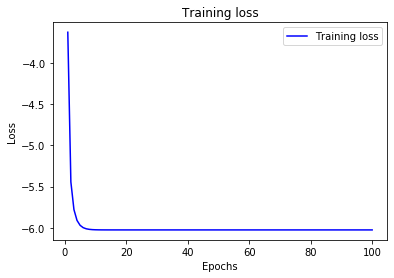

0.5466666666666666


In [7]:
(train_data,train_labels),(test_data,test_labels) = load_balance_data("https://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data")
X_train = np.array(train_data)
Y_train = np.array(train_labels)
X_test = np.array(test_data)
Y_test = np.array(test_labels)

cg = computation_graph(X_train,Y_train)
loss = cg.train_network(X_train,Y_train,epochs=100,decay_rate=0.01,eta=0.1)
accuracy = cg.test_network(X_test,Y_test)

import matplotlib.pyplot as plt
loss_values = loss
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'b',label='Training loss')

plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(accuracy)

Predicted Y1 - [0.77250458 0.09582863 0.13166678] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.77195422 0.09608951 0.13195628] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.77238698 0.09588437 0.13172865] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.77231408 0.09591892 0.131767  ] 	 Actual Y2 - [1. 0. 0.]
Predicted Y1 - 0 	 Actual Y2 - 1.0
Predicted Y1 - [0.77201603 0.0960602  0.13192377] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.77189174 0.09611913 0.13198913] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.77209263 0.09602389 0.13188348] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.77204843 0.09604484 0.13190673] 	 Actual Y2 - [0. 1. 0.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted Y1 - [0.77252305 0.09581988 0.13165707] 	 Actual Y2 - [0. 0. 1.]
Predicted Y1 - 0 	 Actual Y2 - 0.0
Predicted 

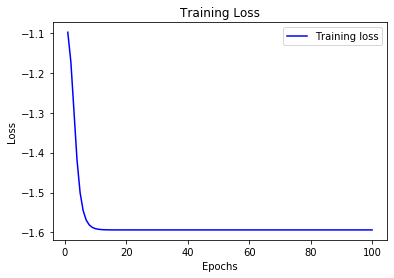

Accuracy:  0.66


In [6]:
(train_data,train_labels),(test_data,test_labels) = load_iris_data("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data")
X_train = np.array(train_data)
Y_train = np.array(train_labels)
X_test = np.array(test_data)
Y_test = np.array(test_labels)

cg = computation_graph(X_train,Y_train)
loss = cg.train_network(X_train,Y_train,epochs=100,decay_rate=0.01,eta=0.1)
accuracy = cg.test_network(X_test,Y_test)

import matplotlib.pyplot as plt
loss_values = loss
epochs = range(1,len(loss_values)+1)
plt.plot(epochs,loss_values,'b',label='Training loss')

plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print("Accuracy: ",accuracy)